# Balanceamento dos dados

Suponha que você esteja trabalhando em uma empresa de transações bancárias que possui 3% das transações fraudulentas e seu modelo atingiu uma acurácia de 95%. O modelo produzido é bom?

- transações = 10000
- transações ok = 9700
- transações fraudulentas = 300

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


Se classificássemos todas as transações como não fraudulentas?
$$Acurácia = \frac{TP + TN}{TP+FP+TN+FN} = \frac{0+9700}{0+0+9700+300} = 0.97$$

<br>
Alimentar dados desequilibrados ao seu classificador pode torná-lo tendencioso em favor da classe majoritária, simplesmente porque ele não tem dados suficientes para aprender sobre a minoria.
É devido à isso que precisamos balancear as classes antes de treinar um modelo. As duas formas de fazermos isso são:


## Undersampling x Oversampling

1. Undersampling: diminuir a quantidade de amostras da classe majoritária para igualar a minoritária
2. Upsampling: aumentar a quantidade de amostras da classe minoritária para igualar com a majoritária

![Title](images/resampling.png)

*OBSERVAÇÃO*: fazer balanceamento apenas entre as amostras de treinamento!!!

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("../data/bank-full.csv")

# Separar feature e target
y = df['Target'].copy()
X = df.drop('Target', axis=1).copy()
X = df.select_dtypes(include='number').copy()

# particionar dados
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.99, random_state=42) 

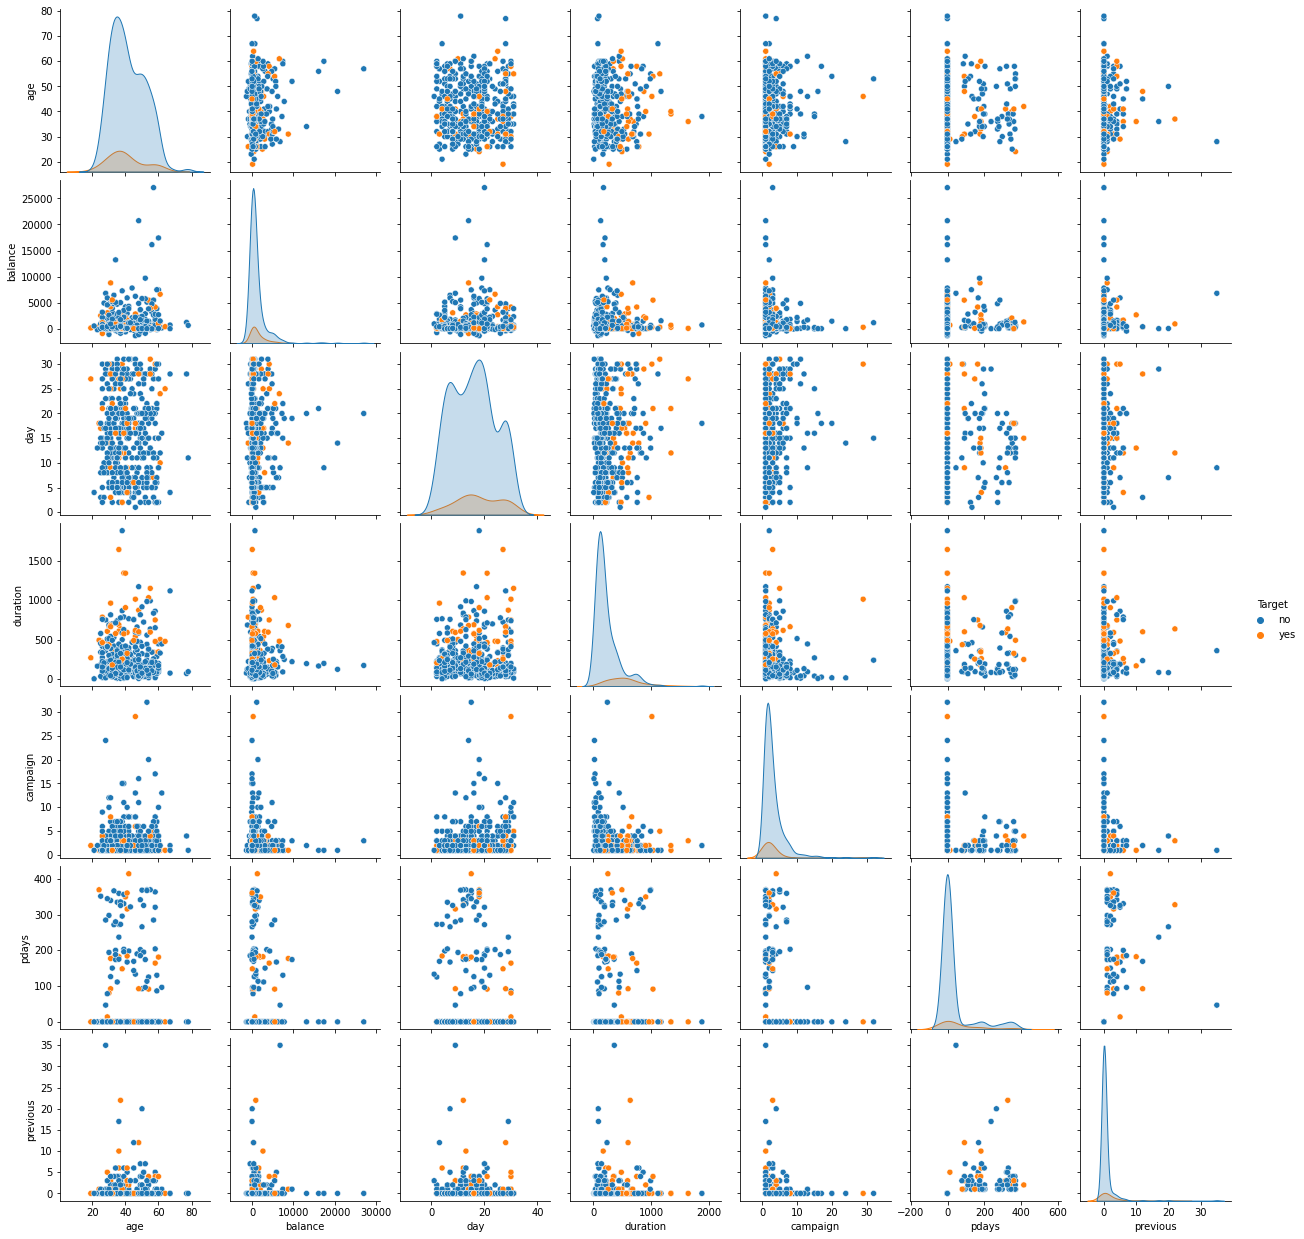

In [7]:
sns.pairplot(data=pd.concat([X_train, y_train], axis=1), hue="Target")

## [Oversampling](https://imbalanced-learn.org/stable/over_sampling.html)

- __[RandomOverSampler](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html#imblearn.over_sampling.RandomOverSampler)__ <br>
Uma maneira de combater esse problema é gerar novas amostras nas classes que estão sub-representadas. A estratégia mais ingênua é gerar novas amostras por amostragem aleatória com reposição das amostras atuais disponíveis.

<img src="images/comparison_over_sampling_002.png" width="500px"/>

Como temos apenas uma repetição das amostras os novos pontos aparecem em cima dos antigos.

In [8]:
from imblearn.over_sampling import RandomOverSampler 
from collections import Counter

print('Original dataset shape %s' % Counter(y_train))
sm = RandomOverSampler(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Original dataset shape %s' % Counter(y_res))

Original dataset shape Counter({'no': 399, 'yes': 53})
Original dataset shape Counter({'no': 399, 'yes': 399})


In [9]:
pd.DataFrame(X_res).duplicated().sum()

346

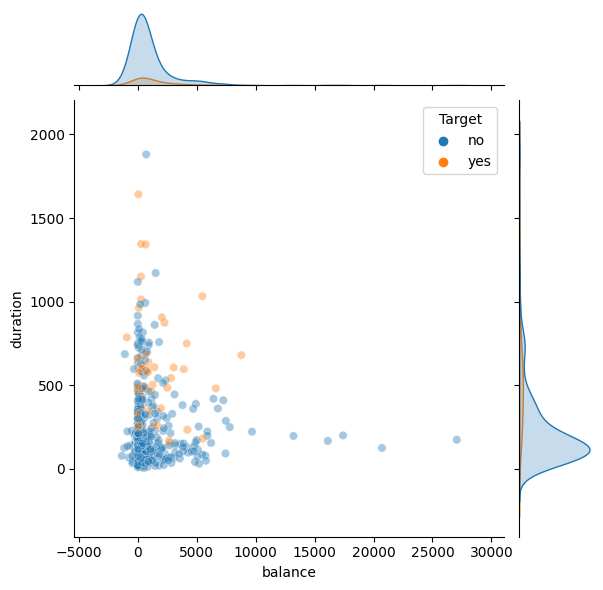

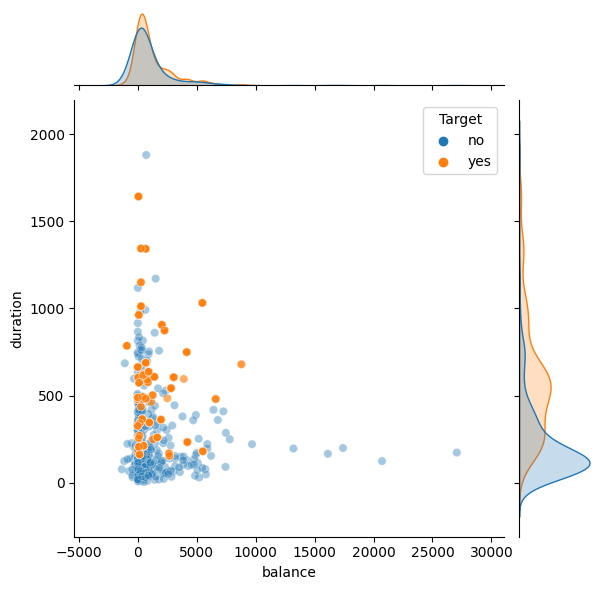

In [10]:
sns.jointplot(data=X_train, x='balance', y='duration', hue=y_train, alpha=0.4)
sns.jointplot(data=X_res, x='balance', y='duration', hue=y_res, alpha=0.4)

In [11]:
X_res.head()

,age,balance,day,duration,campaign,pdays,previous
0,41,59,15,75,8,-1,0
1,41,0,16,330,4,-1,0
2,43,46,27,63,8,-1,0
3,48,2263,29,874,2,-1,0
4,30,1286,28,44,12,-1,0


Se repetir os dados é um problema podemos utilizar o parâmetro de `shrinkage` que controla a dispersão das novas amostras geradas.


<img src="images/comparison_over_sampling_003.png" width="500px"/>

In [12]:
# !pip install pandas numpy sklearn matplotlib imbalanced-learn==0.9.0 seaborn

In [13]:
!pip show imbalanced-learn

Name: imbalanced-learn
Version: 0.9.0
Summary: Toolbox for imbalanced dataset in machine learning.
Home-page: https://github.com/scikit-learn-contrib/imbalanced-learn
Author: 
Author-email: 
License: MIT
Location: /home/patricia/Documentos/LC/aula_venv/lib/python3.9/site-packages
Requires: joblib, numpy, scikit-learn, scipy, threadpoolctl
Required-by: 


Original dataset shape Counter({'no': 399, 'yes': 53})
Original dataset shape Counter({'no': 399, 'yes': 399})


<Figure size 500x500 with 0 Axes>

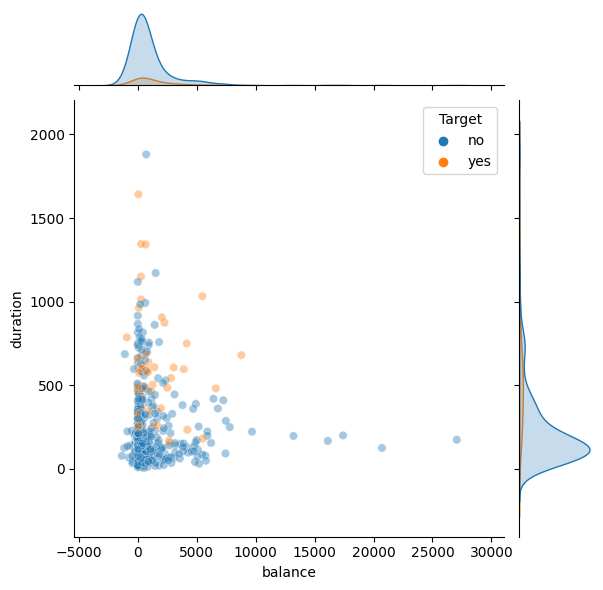

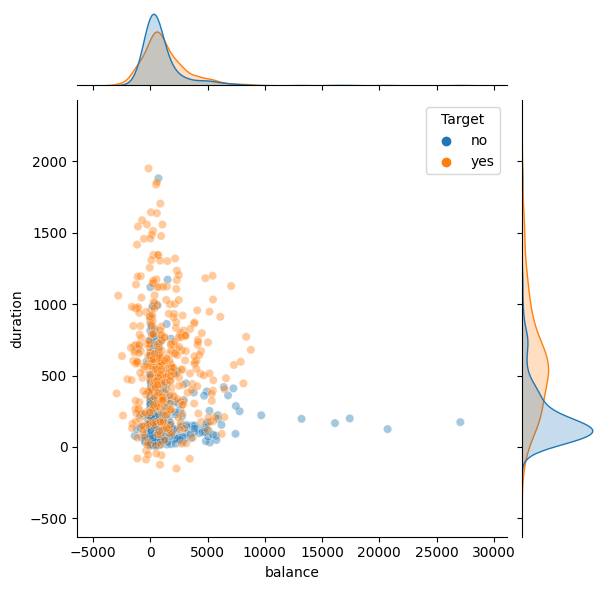

In [21]:
print('Original dataset shape %s' % Counter(y_train))
sm = RandomOverSampler(random_state=42, shrinkage=1)
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Original dataset shape %s' % Counter(y_res))

sns.jointplot(data=X_train, x='balance', y='duration', hue=y_train, alpha=0.4)
sns.jointplot(data=X_res, x='balance', y='duration', hue=y_res, alpha=0.4);

- [SMOTE (Synthetic Minority Oversampling Technique)](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html) <br>
Enquanto o `RandomOverSampler` está sobre-amostrando duplicando algumas das amostras originais da classe minoritária, `SMOTE` e `ADASYN` geram novas amostras por interpolação. No entanto, o método de interpolação/geração novas amostras sintéticas diferem. <br> <br>

A implementação básica do `SMOTE` não faz nenhuma distinção entre amostras fáceis e difíceis de serem classificadas e usam a regra dos vizinhos mais próximos para interpolar novos dados.
<br> 

A ideia geral do __SMOTE__ é a geração de dados sintéticos entre cada amostra da __classe minoritária e seus “k” vizinhos mais próximos__. Ou seja, para cada uma das amostras da classe minoritária são localizados seus “k” vizinhos mais próximos (por padrão k = 5). Em seguida, é desenhada uma linha entre os pontos e seus vizinhos e um ponto aleatório é adicionado.

<img src="https://miro.medium.com/max/875/1*CG712DHQL_ZMS3gAEGd_5w.jpeg" text="https://towardsdatascience.com/smote-synthetic-data-augmentation-for-tabular-data-1ce28090debc">

Na imagem, o SMOTE foi aplicado em x1 considerando os 3 vizinhos mais próximos (x2, x3 e x4) para gerar os dados sintéticos s1, s2 e s3.

Embora o SMOTE seja uma técnica que permite a geração de dados tabulares sintéticos, tal algoritmo por si só possui algumas limitações:
-  __SMOTE trabalha apenas com dados contínuos__ (ou seja, não é projetado para gerar dados sintéticos categóricos)
- os __dados sintéticos gerados são linearmente dependentes, o que pode causar um viés nos dados gerados__ e consequentemente produzir um modelo superajustado.
- SMOTE não pode ter outliers

Original dataset shape Counter({'no': 399, 'yes': 53})
Original dataset shape Counter({'no': 399, 'yes': 399})


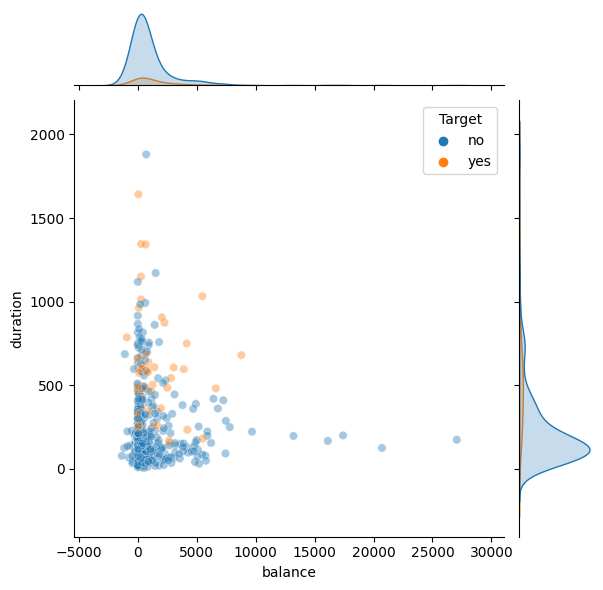

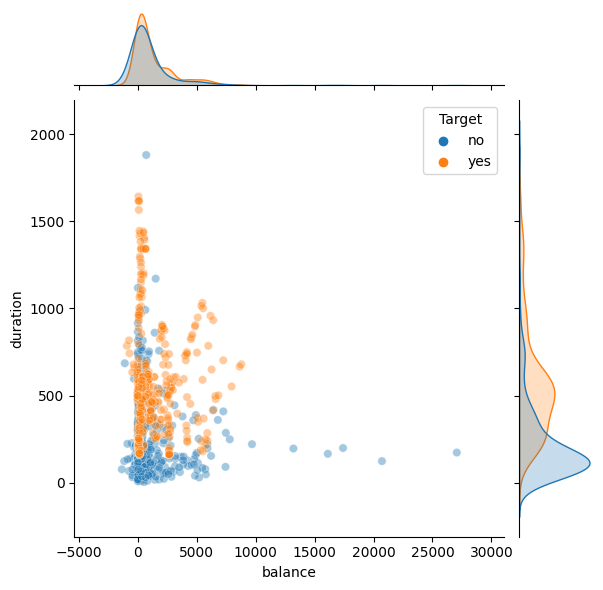

In [15]:
from imblearn.over_sampling import SMOTE 
from collections import Counter

print('Original dataset shape %s' % Counter(y_train))
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Original dataset shape %s' % Counter(y_res))

sns.jointplot(data=X_train, x='balance', y='duration', hue=y_train, alpha=0.4)
sns.jointplot(data=X_res, x='balance', y='duration', hue=y_res, alpha=0.4)

- [ADASYN (Adaptive Synthetic)](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.ADASYN.html#imblearn.over_sampling.ADASYN)
<br>

O `ADASYN` se concentra em gerar amostras próximas às amostras originais que são classificadas erroneamente usando um classificador k-Nearest Neighbors.

ADASYN é uma técnica baseada no algoritmo SMOTE para geração de dados sintéticos. A diferença entre ADASYN e SMOTE é que ADASYN implementa uma metodologia que detecta aquelas amostras da classe minoritária encontradas em espaços dominados pela classe majoritária, isto para gerar amostras nas áreas de menor densidade da classe minoritária. Ou seja, o ADASYN se concentra nas amostras da classe minoritária que são difíceis de classificar porque estão em uma área de baixa densidade.

<img src=https://miro.medium.com/max/875/1*iXHQaRrdIJLRsxxjEnr67Q.jpeg text="https://towardsdatascience.com/smote-synthetic-data-augmentation-for-tabular-data-1ce28090debc">

No ADASYN, consideramos uma distribuição de densidade que decide o número de amostras sintéticas a serem geradas para um determinado ponto, enquanto no SMOTE há um peso uniforme para todos os pontos minoritários.

Original dataset shape Counter({'no': 399, 'yes': 53})
Original dataset shape Counter({'yes': 406, 'no': 399})


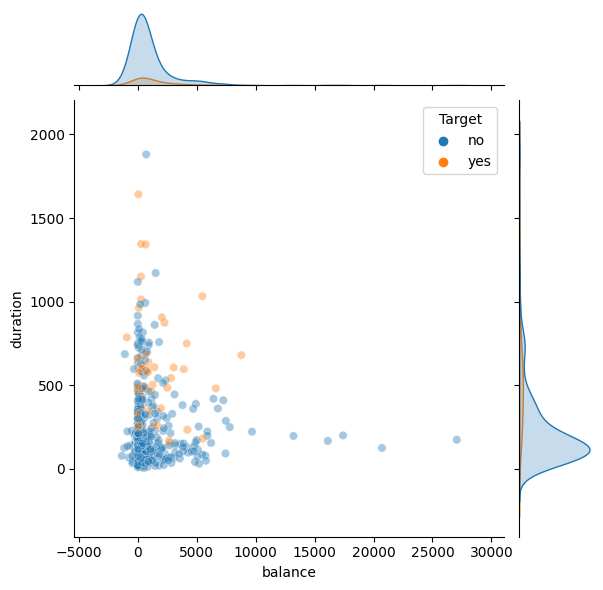

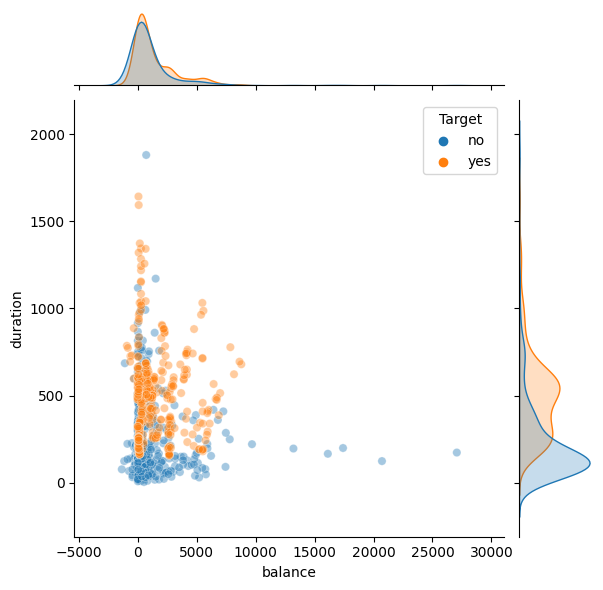

In [16]:
from imblearn.over_sampling import ADASYN 
from collections import Counter

print('Original dataset shape %s' % Counter(y_train))
sm = ADASYN(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Original dataset shape %s' % Counter(y_res))

sns.jointplot(data=X_train, x='balance', y='duration', hue=y_train, alpha=0.4)
sns.jointplot(data=X_res, x='balance', y='duration', hue=y_res, alpha=0.4)

Nem o SMOTE nem ADASYN aceitam uma mistura de variáveis numéricas e categóricas (porquê?). Caso haja variáveis categóricas, pode-se usar uma extensão do SMOTE denominada [SMOTENC](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTENC.html#imblearn.over_sampling.SMOTENC). Se há apenas variáveis categóricas é indicado usar a extensão [SMOTEN](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTEN.html#imblearn.over_sampling.SMOTEN) <br>


#### SMOTE x ADASYN

<img src=https://imbalanced-learn.org/stable/_images/sphx_glr_plot_comparison_over_sampling_006.png width=600>



## [Undersampling](https://imbalanced-learn.org/stable/under_sampling.html)

- [RandomUnderSampler](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html)

Original dataset shape Counter({'no': 399, 'yes': 53})
Original dataset shape Counter({'no': 53, 'yes': 53})


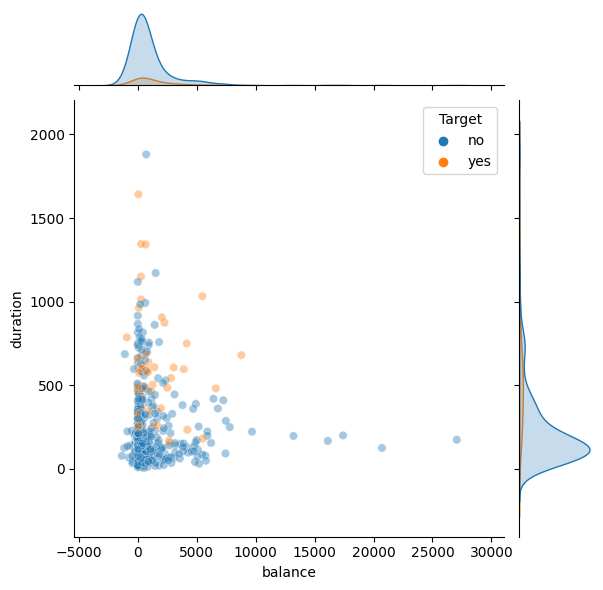

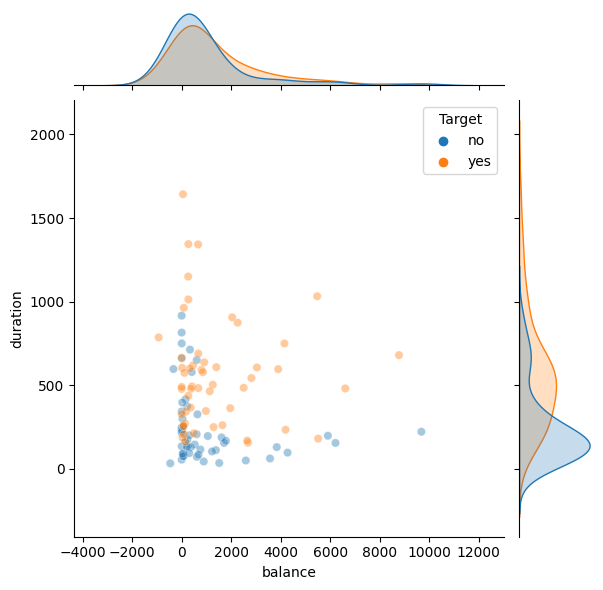

In [17]:
from imblearn.under_sampling import RandomUnderSampler 
from collections import Counter

print('Original dataset shape %s' % Counter(y_train))
sm = RandomUnderSampler(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Original dataset shape %s' % Counter(y_res))

sns.jointplot(data=X_train, x='balance', y='duration', hue=y_train, alpha=0.4)
sns.jointplot(data=X_res, x='balance', y='duration', hue=y_res, alpha=0.4)

- [EditedNearestNeighbours](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.EditedNearestNeighbours.html) <br>
Aplica um algorítimo de nearest-neighbors algorithm e "edita” o dataset removendo amostras que não correspondem suficientemente com a sua vizinhança.

<img src="images/ENN.png" width=500 text="https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.590.5284&rep=rep1&type=pdf">

Original dataset shape Counter({'no': 399, 'yes': 53})
Original dataset shape Counter({'no': 320, 'yes': 53})


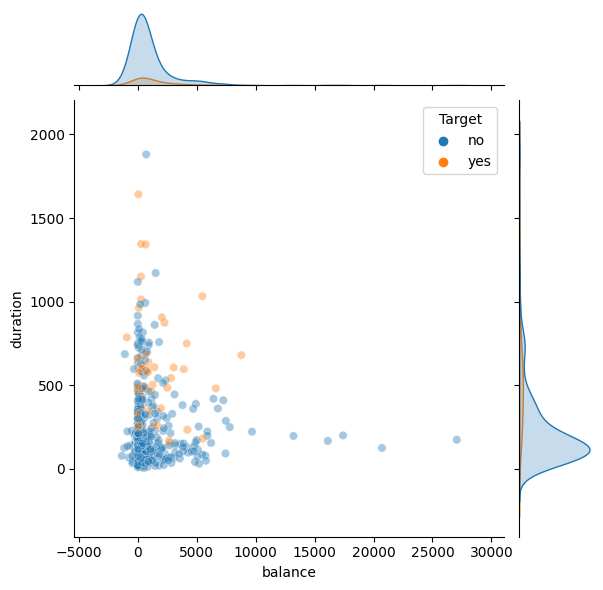

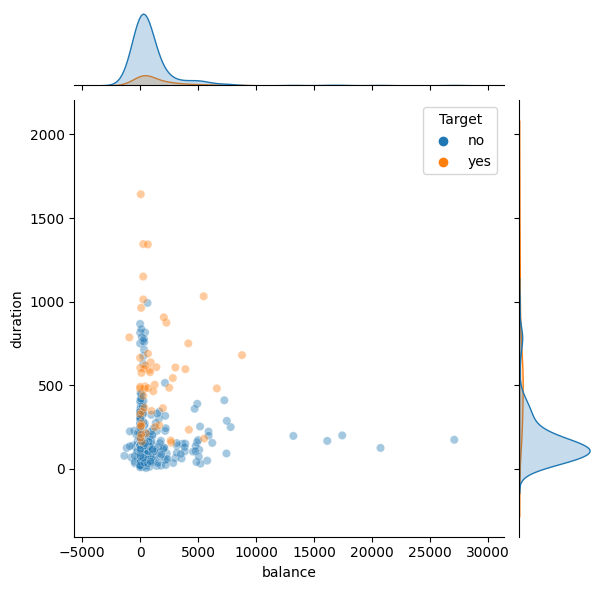

In [18]:
from imblearn.under_sampling import EditedNearestNeighbours 
from collections import Counter

print('Original dataset shape %s' % Counter(y_train))
sm = EditedNearestNeighbours()
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Original dataset shape %s' % Counter(y_res))

sns.jointplot(data=X_train, x='balance', y='duration', hue=y_train, alpha=0.4)
sns.jointplot(data=X_res, x='balance', y='duration', hue=y_res, alpha=0.4)

Problema: Quase nunca é interessante deixarmos dados que poderíamos usar fora do treino do modelo.

## Up + Downsampling

Primeiro é feito um over sampling com SMOTE e depois usa-se o edited nearest-neighbours.

- [SMOTEENN](https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTEENN.html)

<img src="images/SMOTEENN.png" width=500>

Após aplicar o SMOTEENN, a separação entre as classes fica muito mais evidente, além de o conjunto de dados estar balanceado.

Original dataset shape Counter({'no': 399, 'yes': 53})
Original dataset shape Counter({'yes': 326, 'no': 285})


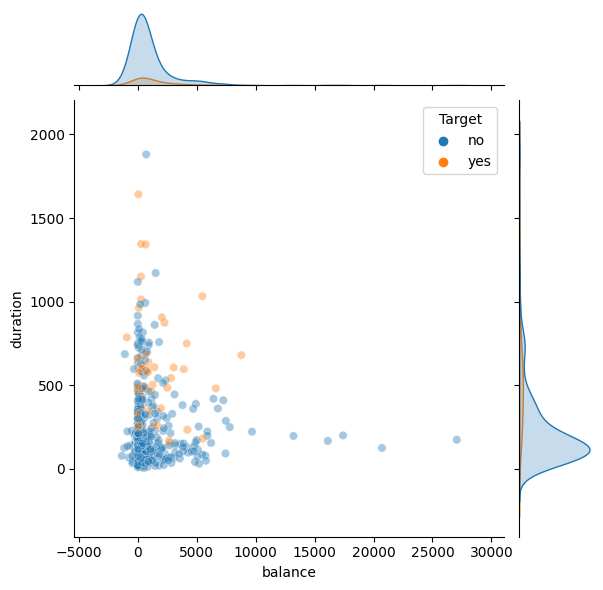

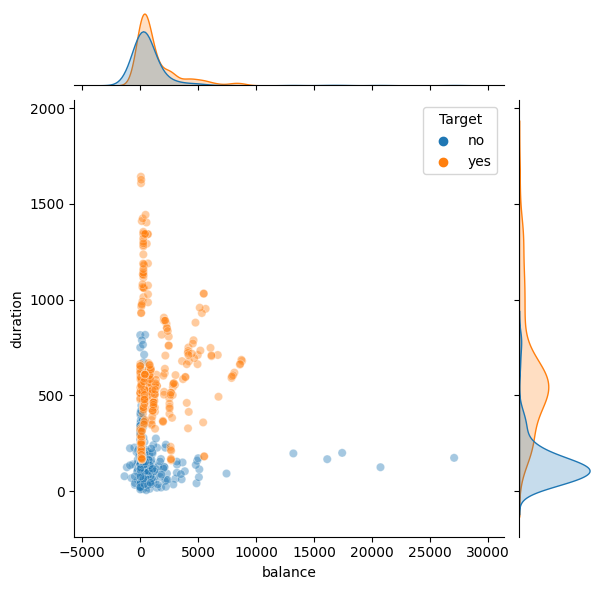

In [19]:
from imblearn.combine import SMOTEENN 
from collections import Counter

print('Original dataset shape %s' % Counter(y_train))
sm = SMOTEENN()
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Original dataset shape %s' % Counter(y_res))

sns.jointplot(data=X_train, x='balance', y='duration', hue=y_train, alpha=0.4)
sns.jointplot(data=X_res, x='balance', y='duration', hue=y_res, alpha=0.4)

## Penalização no algoritmo
A próxima tática é usar algoritmos de aprendizado que penalizam erros de classificação na classe minoritária ao aumentar o custo desses erros. 

Durante o processo de treinamento do modelo, usamos o argumento `class_weight='balanced'` para penalizar os erros cometidos na classe minoritária por um valor proporcional à sua sub-representação.


#### Como utilizar essas classes com o cross-validation?

## Exercício

Escolha pelo menos duas técnicas de tratamento de classes desbalanceadas e aplique no dataset "data/bank-full.csv" e compare a performance do modelo.

## Material extra de estudo
- [Common pitfalls and recommended practices](https://imbalanced-learn.org/stable/common_pitfalls.html)
- [classification_report_imbalanced](https://imbalanced-learn.org/stable/references/generated/imblearn.metrics.classification_report_imbalanced.html)
- [SMOTE, ADASYN](https://towardsdatascience.com/class-imbalance-smote-borderline-smote-adasyn-6e36c78d804)
- [Why we have leakage in CV](https://medium.com/lumiata/cross-validation-for-imbalanced-datasets-9d203ba47e8)
- [Classifier including inner balancing samplers](https://imbalanced-learn.org/stable/ensemble.html)
- https://erasmo-aln.medium.com/oversampling-ou-undersampling-porque-n%C3%A3o-os-dois-juntos-124ecb7fbb6b
